In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


C:\Users\Girija Joshi\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Girija Joshi\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Girija Joshi\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Girija Joshi\anaconda3\envs\

In [2]:
# getting names of all the files in IDC_regular_ps50_idx5and sub dirs
print("Please wait getting all images.....")
files = glob('Resources/IDC_regular_ps50_idx5/*/*/*')

# Example : Resources/IDC_regular_ps50_idx5\\10254\\0\\10254_idx5_x1001_y1001_class0.png'

Please wait getting all images.....


In [3]:
# checking how many are cancer files which has class1 in it
count =0 
for file in files:
    if 'class1' in file:
        count+=1

In [4]:
print('------------------')

print(f'Number Of 1: {count}')
print(f'Number Of 0: {len(files) - count}')
# total number of files
print(f'Total: {len(files)}')

------------------
Number Of 1: 129765
Number Of 0: 123272
Total: 253037


In [5]:
# get 80% of total for training and 20% for testing
train_num = int(len(files) * 0.80)
test_num = len(files) - train_num

In [6]:
# create X and y train data
def find_data(files, lower_limit, upper_limit):
    X = []
    y = []
    
    # tqdm(patient_ids)
    for file in tqdm(files[lower_limit:upper_limit]):
        if file.endswith(".png"):
            # Convering cureent image into PIL image format. PIL image format is RGB format.
            img = tf.keras.preprocessing.image.load_img(file, target_size = (50,50))

            # Keras provides the img_to_array() function for converting a loaded image in PIL format into a NumPy array 
            #for use with deep learning models. The image is convertated into t [height, width, channels]

            # # Arguments
            #         img: PIL Image instance.
            #         data_format: Image data format,
            #             either "channels_first" or "channels_last".
            #         dtype: Dtype to use for the returned array.
            # Returns: A 3D Numpy array.
            
            # The component values are often stored as integer numbers in the range 0 to 255, 
            # the range that a single 8-bit byte can offer,
            pixels = tf.keras.preprocessing.image.img_to_array(img)

            # converting into 0 - 1, This is called as Normalization will help you to remove distortions 
            # caused by lights and shadows in an image.
            pixels /= 255
            X.append(pixels)
            if 'class1' in file:
                y.append(1)
            elif 'class0' in file:
                y.append(0)
    return np.stack(X), y

In [7]:
print(f'Num of training files: {train_num}\nNum of test files:{test_num}')


Num of training files: 202429
Num of test files:50608


In [8]:
X_train,y_train = find_data(files,0, train_num)

100%|█████████████████████████████████████████████████████████████████████████| 202429/202429 [07:08<00:00, 472.21it/s]


In [9]:
X_test, y_test = find_data(files, train_num, len(files))

100%|███████████████████████████████████████████████████████████████████████████| 50608/50608 [02:48<00:00, 300.99it/s]


<AxesSubplot:ylabel='count'>

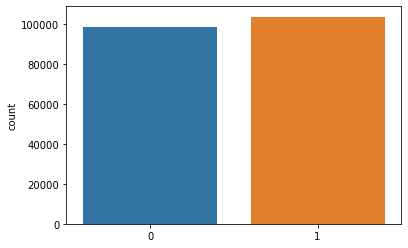

In [10]:
import seaborn as sns
sns.countplot(y_train)

<AxesSubplot:ylabel='count'>

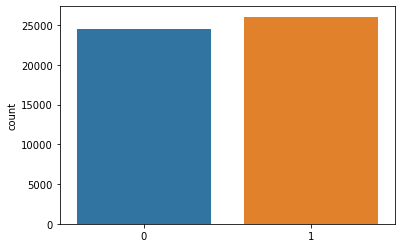

In [11]:
sns.countplot(y_test)

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization

In [13]:
# X_train2 is 4 diemtion we need to convert in 2D
X_train.shape

(202429, 50, 50, 3)

In [14]:
def form_model(inp_shape = (50,50,3)):
    inp = Input(inp_shape)
    m = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    # m = BatchNormalization()(m)
    
    m = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    # m = BatchNormalization()(m)
    
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    
#     m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
#     m = MaxPooling2D(2)(m)
    
    
#     m = Conv2D(256, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
#     m = MaxPooling2D(2)(m)
    
    m = Flatten()(m)
    
    m = Dense(128, activation = "relu")(m)
    out = Dense(1, activation = "sigmoid")(m)
    model = Model(inp, out)
    model.compile(optimizer = keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])
    return model


In [15]:
model = form_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0     

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 25, batch_size=256)

Train on 202429 samples, validate on 50608 samples
Epoch 1/25
 25088/202429 [==>...........................] - ETA: 24:16 - loss: 0.5184 - acc: 0.7444

KeyboardInterrupt: 

In [ ]:
# evaluating and printing results 
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

In [ ]:
pred = model.predict(X_test)

res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test2, res))
print(classification_report(y_test2, res))
